<a href="https://colab.research.google.com/github/Wiaz24/LSTM/blob/batch_training/ProjektNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [395]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import torch
import torch.nn as nn
import pandas_datareader as web
import datetime as dt
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from pathlib import Path
from tqdm.auto import tqdm
import os
print(torch.__version__)

2.0.0+cu118


In [396]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [397]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [398]:
!cp drive/MyDrive/LunarData.csv datasets/LunarData.csv

### Hyprparameters

In [399]:
num_epochs = 100
learning_rate = 0.0001
train_perc = 0.60
batch_size = 32

input_size = 14
hidden_size = 256
num_lstm_layers = 3

seq_length = 48 # 1pkt = 1 godzina
pred_length = 24 # 1pkt = 1 godzina

In [400]:
24*31

744

### Download or load dataset

In [401]:
DATASETS_PATH = Path("datasets")
DATASETS_PATH.mkdir(parents=True, exist_ok=True)

DATASET_NAME = "LunarData.csv"
#DATASET_NAME = "BTC_USD.csv"
DATASET_SAVE_PATH = DATASETS_PATH / DATASET_NAME

alldata = pd.read_csv(DATASET_SAVE_PATH)
  
# start = dt.datetime(2017, 1, 1)
# end = dt.datetime.now()
# alldata = yf.download('BTC-USD', start=start, end=end, progress=False)
# print(f"Saving dataset to: {DATASET_SAVE_PATH}")
# alldata.to_csv(DATASET_SAVE_PATH, index=False)

### Data plot

(Num of examples, number of attributes) = (19272, 14)
[[8.38384380e+03 8.31591237e+03 6.65000000e+01 1.74000000e+02
  5.00000000e+00 1.88000000e+03 3.03961196e+01 3.70000000e+00
  8.26000000e+02 1.24000000e+03 1.97000000e+02 2.00000000e+00
  6.70115727e+01 2.80875800e-02]
 [8.39858668e+03 8.43240018e+03 6.50000000e+01 1.90000000e+02
  5.00000000e+00 1.61700000e+03 2.90931990e+01 3.70000000e+00
  6.63000000e+02 1.09200000e+03 1.47000000e+02 1.00000000e+00
  6.74648161e+01 2.86838800e-02]
 [8.51384077e+03 8.34855467e+03 6.90000000e+01 1.73000000e+02
  5.00000000e+00 1.91300000e+03 3.18780203e+01 3.60000000e+00
  7.16000000e+02 1.33600000e+03 2.31000000e+02 1.00000000e+00
  6.72991887e+01 2.97688200e-02]]


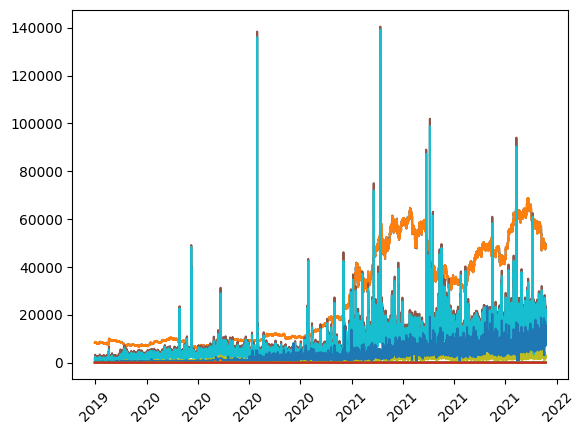

In [402]:
dates = pd.to_datetime(alldata['time'], unit='s')
data = alldata.iloc[:, :-1].to_numpy()

print(f"(Num of examples, number of attributes) = {data.shape}")
date_form = DateFormatter("%Y")
_dates = dates
fig, ax = plt.subplots()
ax.plot(_dates, data)
ax.xaxis.set_major_formatter(date_form)
# Rotacja etykiet osi X
plt.xticks(rotation=45)
print(data[0:3,:])
plt.show()

## Dataloading

In [403]:
data[:,1].reshape(-1,1).shape

(19272, 1)

In [404]:
def sliding_windows(data, seq_length=1):
    x = []
    y = []

    # przykładowo: seq_lenght = 7, pred_length = 3, wtedy:
    for i in range(0, len(data) - seq_length - pred_length, pred_length):  # dla i = 0:
        _x = data[i:(i+seq_length), :]                      # _x = data[0:7, wszystkie cechy],  potem data[3:10,:]
        _y = data[i+seq_length:i+seq_length+pred_length, 0] # _y = data[7:10, open_price] ,    potem data[10:13,1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
outSc = MinMaxScaler()
outSc.fit_transform(data[:,1].reshape(-1,1))
data = sc.fit_transform(data) #normalizacja danych
x, y = sliding_windows(data, seq_length)  #tworzenie ramek uczących i odpowiedzi

print(f"x.shape = {x.shape}, y.shape = {y.shape}")                

x.shape = (800, 48, 14), y.shape = (800, 24)


In [405]:
train_size = int(len(y) * train_perc)
test_size = int((len(y) - train_size)/2)
eval_size = test_size

device = "cuda" if torch.cuda.is_available() else "cpu"

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))
dataX = dataX.to(device)
dataY = dataY.to(device) 

dataset = TensorDataset(dataX, dataY)

indices = torch.randperm(len(dataset)-test_size)

### Losowanie próbek do zbioru uczącego i walidacyjnego

In [406]:
train_indices = indices[:train_size]
eval_indices = indices[train_size:train_size+eval_size]
test_indices = torch.arange(train_size+eval_size, dataX.size(0))

In [407]:
train_indices.shape, eval_indices.shape, test_indices.shape

(torch.Size([480]), torch.Size([160]), torch.Size([160]))

### Tworzenie dataloaderów

In [408]:
trainDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
evalDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(eval_indices))
testDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(test_indices))

In [409]:
features, labels = next(iter(trainDataLoader))
features.shape, labels.shape, features.device, labels.device

(torch.Size([32, 48, 14]),
 torch.Size([32, 24]),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

## Model

In [410]:
class LSTM(nn.Module):

    def __init__(self, pred_length, input_size, hidden_size, num_lstm_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = pred_length
        self.num_lstm_layers = num_lstm_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_lstm_layers, x.size(0), self.hidden_size).cuda())

        c_0 = Variable(torch.zeros(
            self.num_lstm_layers, x.size(0), self.hidden_size).cuda())
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        # Reshape for dense layer
        out = output[:, -1, :]
        
        out = self.fc(out)
        
        return out

## Training

In [411]:
!git clone https://gist.github.com/NTT123/4596e5533e573c8ceab2f319ab5d36a2 jslog
import random
import math
import time
from jslog.jslogger import JSLogger

logger = JSLogger('train/test loss', ['train', 'test'])

fatal: destination path 'jslog' already exists and is not an empty directory.


In [412]:
%%time
logger.show()
lstm = LSTM(pred_length, input_size, hidden_size, num_lstm_layers)
lstm.to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in tqdm(range(num_epochs)):
    #uczenie modelu
    lstm.train()
    for inputs, labels in trainDataLoader:
        optimizer.zero_grad()
        outputs = lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

    # ewaluacja modelu
    lstm.eval()
    with torch.inference_mode():
        for inputs, labels in evalDataLoader:
            outputs = lstm(inputs)
            loss = criterion(outputs, labels)
            eval_loss = loss.item()

    # wykres funkcji straty dla zbioru treningowego i ewaluacyjnego
    logger.log(epoch, {'train': train_loss, 'test': eval_loss})
    # !clear
    # plt.plot(train_loss, label='Train')
    # plt.plot(eval_loss, label='Eval')
    # plt.legend()
    # plt.title('Loss over epochs')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.show()

    # outputs = lstm(trainX)
    # optimizer.zero_grad()
    # if first == True:
    #   print(outputs.shape)
    #   first = False
    # # obtain the loss function
    
    # trainY = trainY.reshape(-1, pred_length)
    # loss = criterion(outputs, trainY)
    
    # loss.backward()
    
    # optimizer.step()
    # if epoch % 10 == 0:
    #   print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()))

# print(outputs.shape)
# print(trainY.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 13.5 s, sys: 193 ms, total: 13.7 s
Wall time: 14.2 s


# Testing

In [413]:
lstm.eval()
dataX.to('cpu')
with torch.inference_mode():
  predictions = lstm(dataX)
predictions = predictions.to('cpu')
dataY = dataY.to('cpu')

In [414]:
predictions.shape, dataY.shape

(torch.Size([800, 24]), torch.Size([800, 24]))

In [415]:
loss = criterion(predictions, dataY)
print(f"Loss = {loss}")

Loss = 0.00046195421600714326


In [416]:
predictions_np = predictions.reshape(-1,1).data.numpy()
dataY_np = dataY.reshape(-1,1).data.numpy()

In [417]:
predictions_np.shape, dataY_np.shape

((19200, 1), (19200, 1))

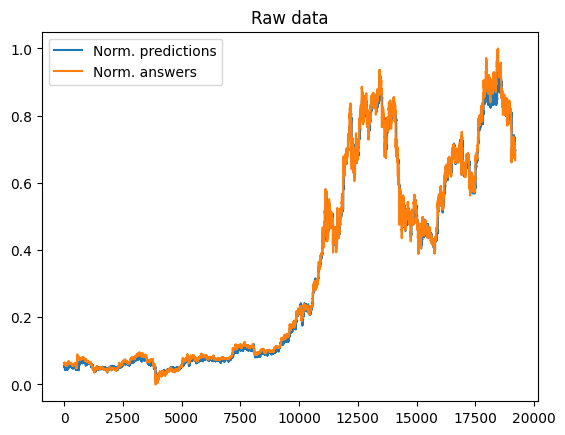

In [418]:
plt.plot(predictions_np, label="Norm. predictions")
plt.plot(dataY_np, label="Norm. answers")
plt.legend()
plt.title("Raw data")
plt.show()

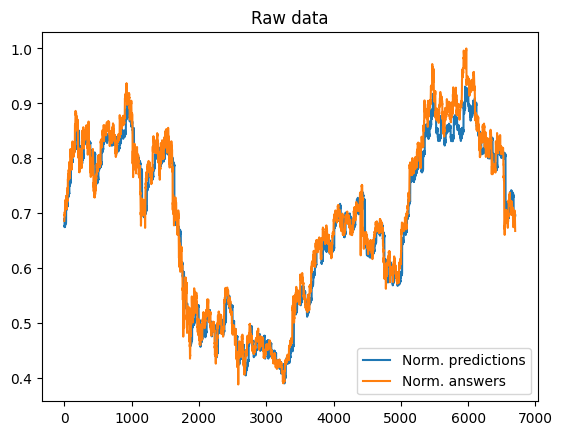

In [419]:
plt.plot(predictions_np[12500:], label="Norm. predictions")
plt.plot(dataY_np[12500:], label="Norm. answers")
plt.legend()
plt.title("Raw data")
plt.show()

In [420]:
dataY_np_unorm = outSc.inverse_transform(dataY_np)
predictions_np_unorm = outSc.inverse_transform(predictions_np)

In [421]:
dataY_np_unorm[:3], dataY_np[:3]

(array([[8658.167],
        [8641.568],
        [8759.063]], dtype=float32),
 array([[0.06396887],
        [0.06371072],
        [0.06553807]], dtype=float32))

In [422]:
_dates = dates[seq_length : seq_length+dataY_np.size]
print(_dates.size)

19200


In [423]:
int(train_size+eval_size)

640

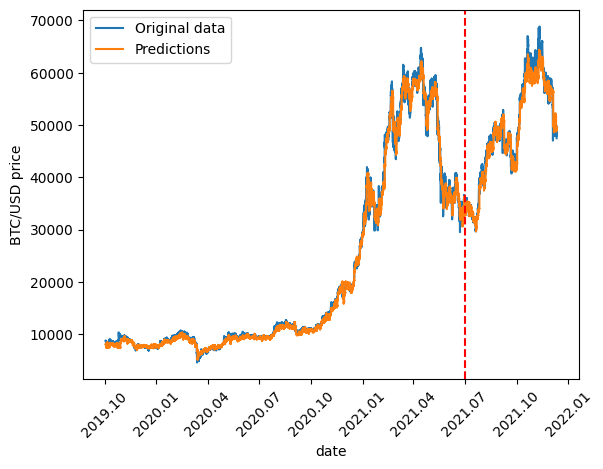

In [424]:
# Tworzenie wykresu
fig, ax = plt.subplots()
ax.plot(_dates, dataY_np_unorm, label="Original data")
ax.plot(_dates, predictions_np_unorm, label="Predictions")
ax.axvline(x=_dates[(train_size+eval_size)*pred_length], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()

# plt.plot(predictions_np_unorm, label="predictions")
# plt.plot(dataY_np_unorm, label="answers")
# plt.legend()
# plt.title("Predicted data")
# plt.show()

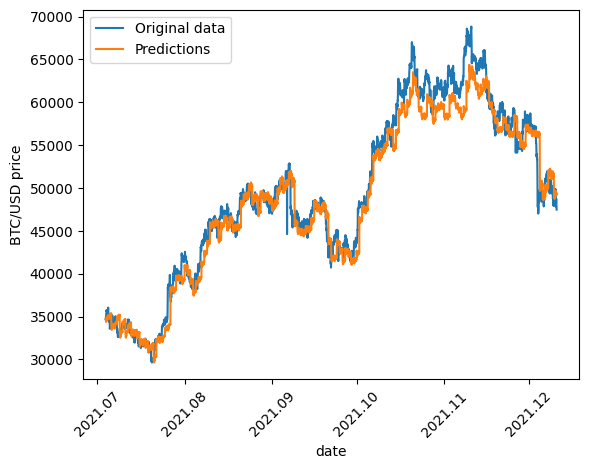

In [425]:
# Tworzenie wykresu
fig, ax = plt.subplots()
startInd = int(_dates.size*(train_perc+1)/2)
ax.plot(_dates[startInd:], dataY_np_unorm[startInd:], label="Original data")
ax.plot(_dates[startInd:], predictions_np_unorm[startInd:], label="Predictions")
#ax.axvline(x=dates[train_size], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()

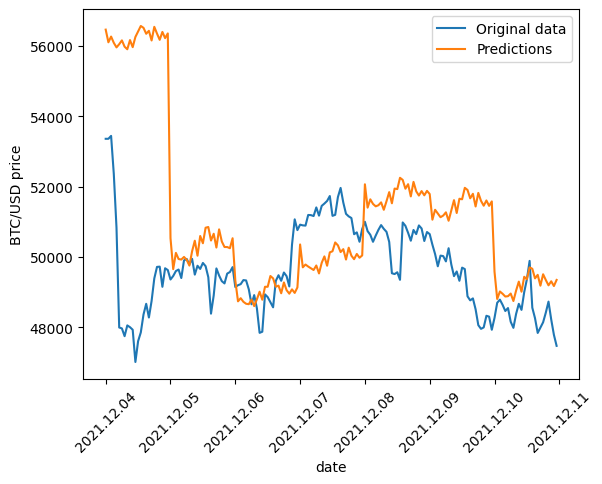

In [426]:
# Tworzenie wykresu
fig, ax = plt.subplots()
startInd = int(_dates.size*train_perc)
ax.plot(_dates[-168:], dataY_np_unorm[-168:], label="Original data")
ax.plot(_dates[-168:], predictions_np_unorm[-168:], label="Predictions")
#ax.axvline(x=dates[train_size], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m.%d")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()